In [145]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import matplotlib

from matplotlib import pyplot as plt

import matplotlib.colors as mcolors

font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)
matplotlib.pyplot.rc('font', **font)


colors=list(mcolors.TABLEAU_COLORS)




In [146]:


from jetset.poly_fit import do_log_Parab_FIT,do_linear_fit
from jetset.loglog_poly_model import LogLinear
from jetset.model_manager import FitModel
from jetset.minimizer import fit_SED
from jetset.data_loader import Data,ObsData

In [147]:
def n_distr_plot(j,ax,c=None):
    x=my_jet.electron_distribution.gamma
    y=my_jet.electron_distribution.n_gamma
    ax.plot(np.log10(x),np.log10(y*x*x*x),color=c)
    

In [200]:


def get_gamma_3p(j):
    j.electron_distribution.update()
    
    x=np.log10(j.electron_distribution.gamma)
    y=np.log10(j.electron_distribution.n_gamma)+3*x
    y_p=y.max()
    x_p=x[np.argmax(y)]
    p,err=do_log_Parab_FIT(x,y,x_p,y_p,-1,x_range=[x_p-0.5,x_p+0.5],dy=np.ones(x.size))
    return p


def get_pl_slope_n(j,x_range):
    
    x=np.log10(j.electron_distribution.gamma)
    y=np.log10(j.electron_distribution.n_gamma)
    
   
    p,err=do_linear_fit(x,y,x_range=x_range,dy=np.ones(x.size))
   
    return p,err
    

def get_log_par_peak(x_p,y_p,j,comp):
    c=j.get_spectral_component_by_name(comp)
    x=np.log10(c.SED.nu.value)
    y=np.log10(c.SED.nuFnu.value)

    p,err=do_log_Parab_FIT(x,y,x_p,y_p,-0.1,x_range=[x_p,x_p+1],dy=np.ones(x.size))
    p,err=do_log_Parab_FIT(x,y,p[0],p[1],p[2],x_range=[p[0],p[0]+1],dy=np.ones(x.size))

    return p,err


def get_pl_slope_SED_1(j,comp,x_range):
    
    c=j.get_spectral_component_by_name(comp)
    x=np.log10(c.SED.nu.value)
    y=np.log10(c.SED.nuFnu.value)
    
    p,err=do_linear_fit(x,y,x_range=x_range,dy=np.ones(x.size))
  
    
    return p,err




def get_pl_slope_SED_2(j,comp,x_range):
    
    loglog_pl=FitModel( name=None,loglog_poly=LogLinear())
    
    c=j.get_spectral_component_by_name(comp)
    x=c.SED.nu.value
    y= c.SED.nuFnu.value
    
    
    data=Data(n_rows=x.shape[0])
    data.set_field('x',x)
    data.set_field('y',y)
    #data.set_field('dy',value=1E-15)
    data.set_meta_data('z',j.parameters.z_cosm.val)
    data.set_meta_data('restframe','obs')
    data.set_meta_data('data_scale','lin-lin')
    
    sed_data=ObsData(data_table=data)
    loglog_pl=FitModel( name=None,loglog_poly=LogLinear())
    mm,best_fit=fit_SED(loglog_pl,
                         sed_data,
                         10**x_range[0],
                         10**x_range[1],
                         loglog=True,
                         silent=True,
                         fitname='spectral-indices-best-fit',
                         minimizer='lsb')
    
    par=loglog_pl.parameters.get_par_by_name('alpha')
    
    #print(par.best_fit_val,par.best_fit_err)
    return par.best_fit_val,par.best_fit_err,loglog_pl




def nu_p_S_delta_approx(my_jet,gp):
    B=my_jet.parameters.B.val
    delta=my_jet.get_beaming()
    z=my_jet.parameters.z_cosm.val
    return np.log10(3.2E6*B*delta/(1+z))+2*gp

In [186]:
from jetset.plot_sedfit import PlotSED,PlotPdistr,PlotSpecComp
from jetset.jet_model import Jet

In [208]:
my_jet=Jet(electron_distribution='lppl')
my_jet.parameters.r.val=1.0
my_jet.show_model()


-------------------------------------------------------------------------------------------------------------------
jet model description
-------------------------------------------------------------------------------------------------------------------
name: tests  

electron distribution:
 type: lppl  
 electron energy grid size:  1001
 gmin grid : 2.000000e+00
 gmax grid : 1.000000e+06
 normalization  True
 log-values  False

radiative fields:
 seed photons grid size:  100
 IC emission grid size:  50
 source emissivity lower bound :  1.000000e-120
 spectral components:
   name:Sum, state: on
   name:Sync, state: self-abs
   name:SSC, state: on
external fields transformation method: blob

SED info:
 nu grid size :200
 nu mix (Hz): 1.000000e+06
 nu max (Hz): 1.000000e+30

flux plot lower bound   :  1.000000e-30

      name             par type           units             val         phys. bound. min  phys. bound. max   log  frozen
---------------- ------------------- --------------- 

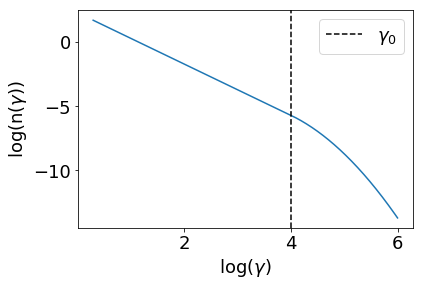

In [209]:
my_jet.eval()
p=my_jet.electron_distribution.plot()
p.ax.axvline(4.0,ls='--',c='black',label=r'$\gamma_0$')
p.ax.legend()

# Synchrotron trends

## Synchrotron: full computation and  $\delta$-approx comparison

(2, 9)

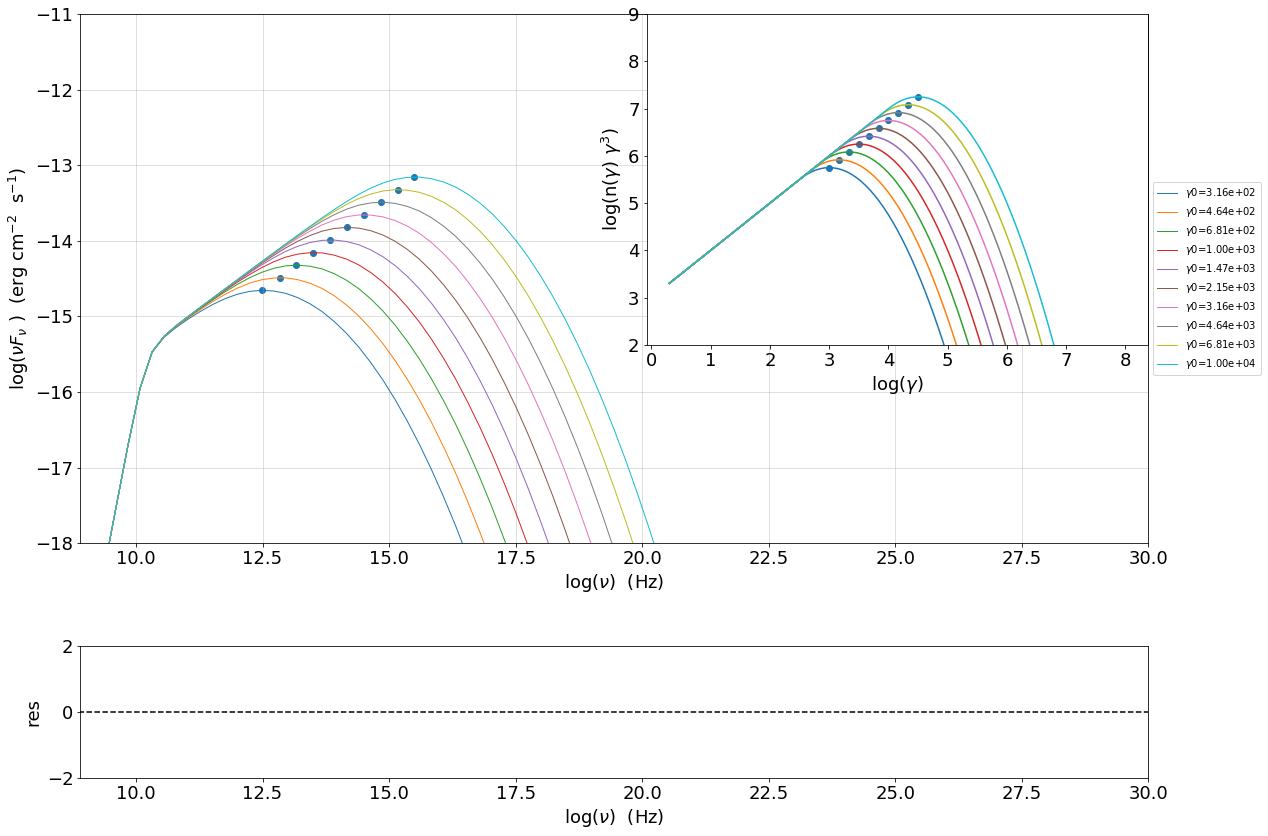

In [189]:
matplotlib.rc('font', **font)

p=PlotSED(figsize=(18,12))

ax=p.fig.add_subplot(222)
my_jet.parameters.gmax.val=1E8
my_jet.parameters.r.val=1.0
my_jet.parameters.s.val=2.0
my_jet.parameters.N.val=500
my_jet.parameters.z_cosm.val=0.05


size=10


#Synch
nu_p_S=np.zeros(size)
nuFnu_p_S=np.zeros(size)


#e- distr 
g_p_e=np.zeros(size)
n3g_p_e=np.zeros(size)

nu_p_S_delta=np.zeros(size)

my_jet.set_IC_mode('off')
for ID,gamma0_log_parab in enumerate(np.logspace(2.5,4,size)):
   
    my_jet.set_nu_grid_size(100)
    my_jet.set_gamma_grid_size(100)
    my_jet.parameters.gamma0_log_parab.val=gamma0_log_parab
    my_jet.eval()
    x_p,y_p=my_jet.get_component_peak('Sync',log_log=True)
    (nu_p_S[ID],nuFnu_p_S[ID],_),err=get_log_par_peak(x_p,y_p,my_jet,'Sync')
    my_jet.electron_distribution.update()
    g_p_e[ID],n3g_p_e[ID],_=get_gamma_3p(my_jet)
    nu_p_S_delta[ID]=nu_p_S_delta_approx(my_jet,g_p_e[ID])
    
    my_jet.plot_model(p,label=r'$\gamma 0$=%2.2e'%gamma0_log_parab,color=colors[ID],auto_label=False,comp='Sync')
    
    n_distr_plot(my_jet,ax,c=colors[ID])
    
    
ax.set_xlabel(r'log($\gamma$)')
ax.set_ylabel(r'log(n($\gamma$) $\gamma^3$)')

p.sedplot.scatter(nu_p_S,nuFnu_p_S)
ax.scatter(g_p_e,n3g_p_e)

p.rescale(y_min=-18,y_max=-11,x_min=8.9,x_max=30)
ax.set_ylim(2,9)

(0, 1.5)

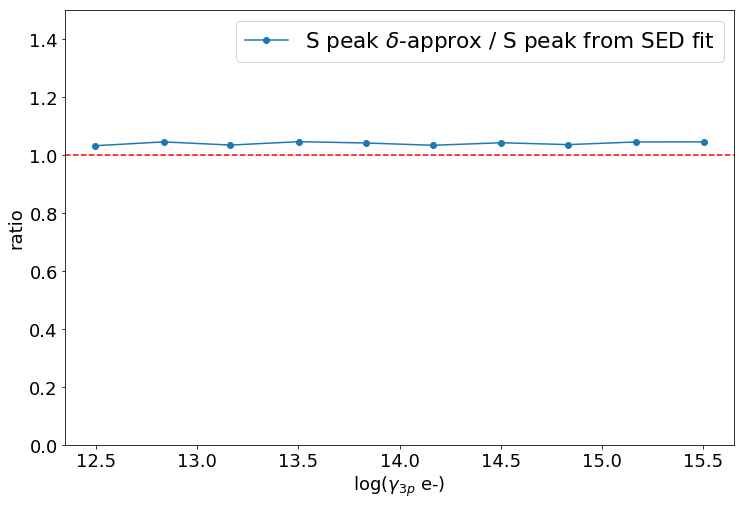

In [190]:

#plt.plot(nu_p_S, 10**(nu_p_S - nu_p_S_delta))
#plt.ylim(0,1.5)


matplotlib.rc('font', **font)

fig = plt.figure(figsize=(12,8))

ax=fig.add_subplot(111)
ax.plot(nu_p_S,10**(nu_p_S - nu_p_S_delta),'-o',label=r'S peak $\delta$-approx / S peak from SED fit')

ax.set_ylabel('ratio')
ax.set_xlabel(r'log($\gamma_{3p}$ e-)')
#ax.axvline(4.0,ls='--',c='black')
ax.axhline(1.0,ls='--',c='red')
ax.legend(fontsize='large',loc='best')
ax.set_ylim(0,1.5)


## Synchrotron trend for $\gamma_{min}$ and electrons low-energy  spectral slope

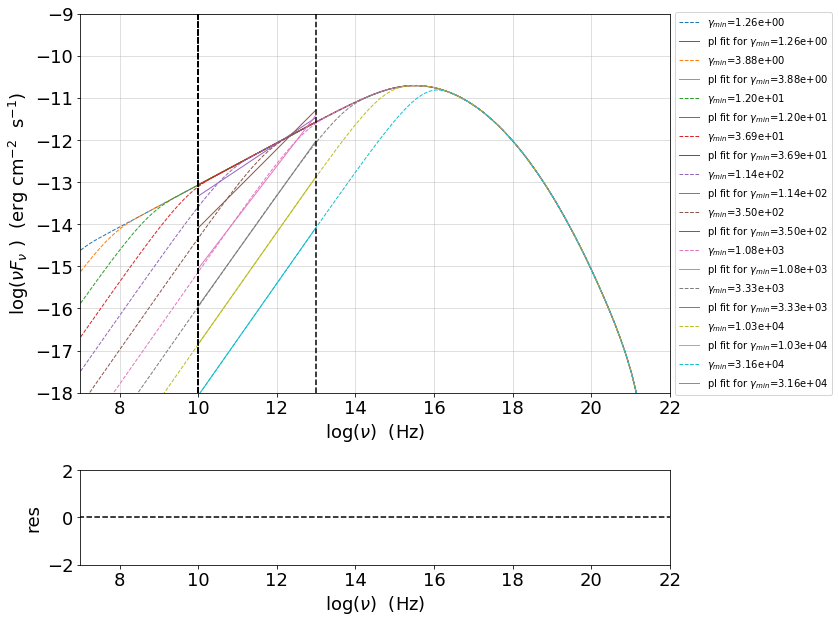

In [191]:
matplotlib.rc('font', **font)

p=PlotSED(figsize=(12,9))

my_jet.parameters.gmax.val=1E7
my_jet.parameters.r.val=1.0
my_jet.parameters.s.val=2.0
my_jet.parameters.N.val=500
my_jet.parameters.z_cosm.val=0.05

my_jet.set_nu_grid_size(500)
my_jet.set_gamma_grid_size(100)
my_jet.set_IC_nu_size(100)

size=10


#Synch
nu_p_S=np.zeros(size)
nuFnu_p_S=np.zeros(size)



S_index=np.zeros(size)
S_index_err=np.zeros(size)

my_jet.set_IC_mode('off')

#Switch off sych self-abs
my_jet.spectral_components.Sync.state='on'

gmin_values=np.logspace(0.1,4.5,size)


 
for ID,gmin in enumerate(gmin_values):
   
   
    my_jet.parameters.gmin.val=gmin
    my_jet.set_N_from_nuFnu(nu_obs=5E16,nuFnu_obs=1E-11)
    my_jet.eval()
    x_p,y_p=my_jet.get_component_peak('Sync',log_log=True)
    S_index[ID],S_index_err[ID],loglog_pl=get_pl_slope_SED_2(my_jet,'Sync',[10,13])

    
    
    my_jet.plot_model(p,label=r'$\gamma_{min}$=%2.2e'%gmin,color=colors[ID],auto_label=False,comp='Sync',line_style='--')
    p.add_model_plot(loglog_pl,label=r'pl fit for $\gamma_{min}$=%2.2e'%gmin,color=colors[ID],line_style='-')

    p.sedplot.axvline([10],ls='--',c='black')
p.sedplot.axvline([13],ls='--',c='black')

p.sedplot.scatter(nu_p_S,nuFnu_p_S)

p.rescale(y_min=-18,y_max=-9,x_min=7,x_max=22)



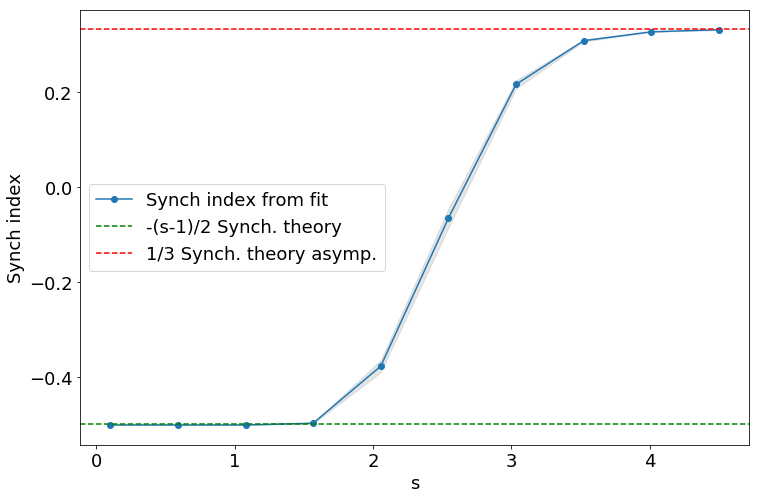

In [192]:
S_spectral_index=S_index-1

matplotlib.rc('font', **font)

fig = plt.figure(figsize=(12,8))

ax=fig.add_subplot(111)
ax.plot(np.log10(gmin_values),S_spectral_index,'-o',label=r'Synch index from fit')
ax.fill_between(np.log10(gmin_values), S_spectral_index - S_index_err, S_spectral_index + S_index_err,
                 color='gray', alpha=0.2)
ax.set_ylabel('Synch index')
ax.set_xlabel(r's')
ax.axhline(-(my_jet.parameters.s.val-1)/2,ls='--',c='green',label='-(s-1)/2 Synch. theory')
ax.axhline(1/3,ls='--',c='red',label='1/3 Synch. theory asymp.')
ax.legend()




## Trends for the inverse Compton and synchrotron emission

## Changing $\gamma_{min}$

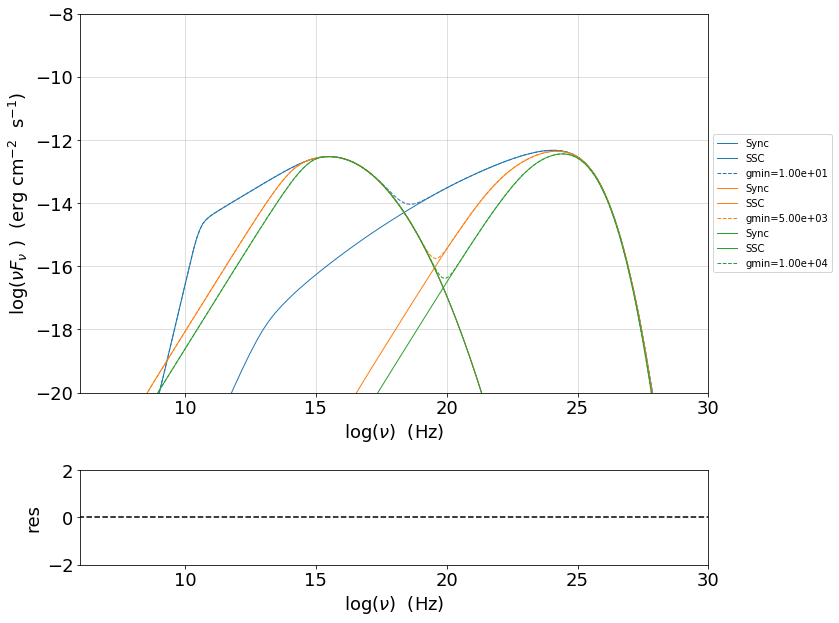

In [193]:
matplotlib.rc('font', **font)
p=PlotSED(figsize=(12,9))


my_jet=Jet(electron_distribution='lppl')

my_jet.parameters.gmax.val=1E8
my_jet.parameters.r.val=1.0


for ID,gmin in enumerate([10,5000,10000]):
   
    my_jet.set_gamma_grid_size(200)
    my_jet.set_IC_nu_size(100)
    my_jet.parameters.gmin.val=gmin
    my_jet.set_N_from_nuFnu(nu_obs=1E17,nuFnu_obs=1E-13)
    my_jet.eval()
    my_jet.plot_model(p,label='gmin=%2.2e'%gmin,color=colors[ID])


## Changing the turn-over energy

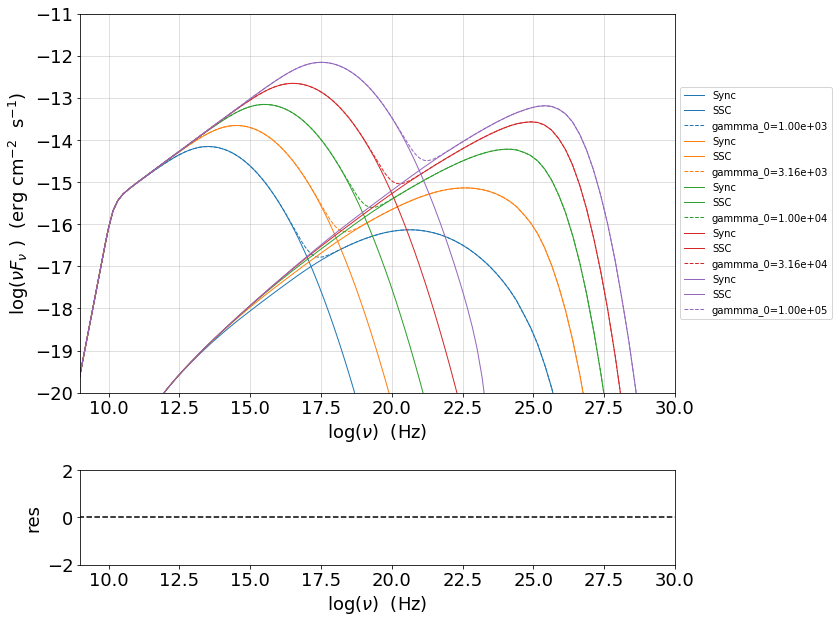

In [194]:
my_jet=Jet(electron_distribution='lppl')

matplotlib.rc('font', **font)
p=PlotSED(figsize=(12,9))

my_jet.parameters.gmax.val=1E8
my_jet.parameters.r.val=1.0
my_jet.parameters.s.val=2.0
my_jet.parameters.N.val=500
my_jet.parameters.z_cosm.val=0.05
for ID,gamma0_log_parab in enumerate(np.logspace(3,5,5)):
   
    my_jet.set_nu_grid_size(1000)
    my_jet.set_gamma_grid_size(200)
    my_jet.set_IC_nu_size(100)
    my_jet.parameters.gamma0_log_parab.val=gamma0_log_parab
    my_jet.eval()
    my_jet.plot_model(p,label='gammma_0=%2.2e'%gamma0_log_parab,color=colors[ID])
    
p.rescale(y_min=-20,y_max=-11,x_min=9)

## Transition from TH to KN regime for the IC emission: changing the curvature in the high-enegy branch of the emitters

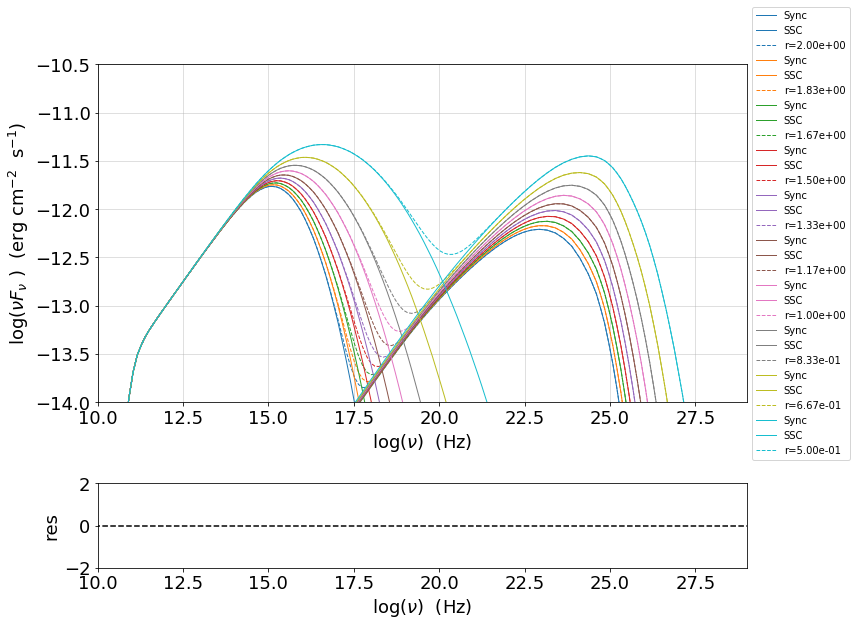

In [202]:
my_jet=Jet(electron_distribution='lppl')

matplotlib.rc('font', **font)
p=PlotSED(figsize=(12,9))

my_jet.parameters.gmax.val=1E8
my_jet.parameters.gamma0_log_parab.val=5E3
my_jet.parameters.B.val=.5

my_jet.nu_max=1E30
my_jet.set_gamma_grid_size(100)
my_jet.set_IC_nu_size(100)

size=10

nu_p_S=np.zeros(size)
nu_p_IC=np.zeros(size)
nuFnu_p_S=np.zeros(size)
nuFnu_p_IC=np.zeros(size)
r_S=np.zeros(size)
r_S_err=np.zeros(size)
r_IC=np.zeros(size)
r_IC_err=np.zeros(size)
r_values=np.linspace(2.0,0.5,size)



for ID,r in enumerate(r_values):
   
    
    my_jet.parameters.r.val=r
    my_jet.set_N_from_nuFnu(nu_obs=1E10,nuFnu_obs=1E-14)
    my_jet.eval()
    my_jet.plot_model(p,label='r=%2.2e'%r,color=colors[ID])
    x_p,y_p=my_jet.get_component_peak('Sync',log_log=True)
    (nu_p_S[ID],nuFnu_p_S[ID],r_S[ID]),err=get_log_par_peak(x_p,y_p,my_jet,'Sync')
    r_S_err[ID]=err[2]
    
    x_p,y_p=my_jet.get_component_peak('SSC',log_log=True)
    (nu_p_IC[ID],nuFnu_p_IC[ID],r_IC[ID]),err=get_log_par_peak(x_p,y_p,my_jet,'SSC')
    r_IC_err[ID]=err[2]
    
    
    
p.rescale(y_min=-14,y_max=-10.5,x_min=10,x_max=29)

the following plot shows the trend for the S curvature (b) and the IC curvature (both measured over one decade starting from the peak) versus the curvature of the electron distribution (r) 

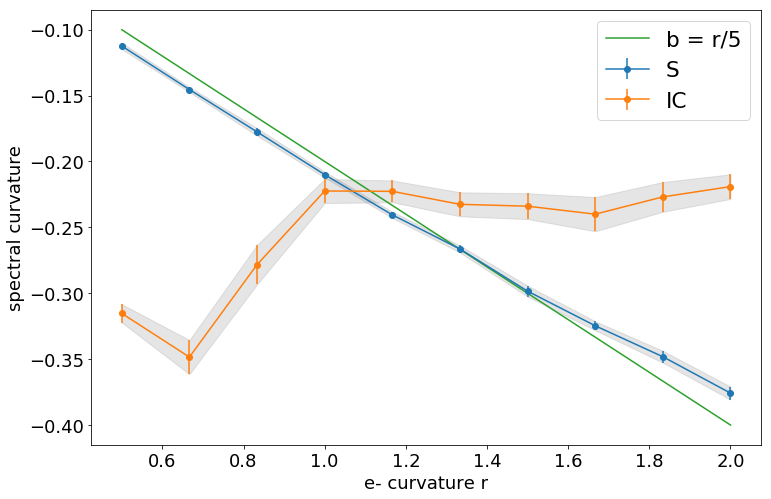

In [207]:
fig = plt.figure(figsize=(12,8))

ax=fig.add_subplot(111)
ax.errorbar(r_values,r_S,yerr=r_S_err,fmt='-o',label='S curvature')
ax.fill_between(r_values, r_S - r_S_err, r_S + r_S_err,
                 color='gray', alpha=0.2)
ax.errorbar(r_values,r_IC,yerr=r_IC_err,fmt='-o',label='IC curvature')
ax.fill_between(r_values, r_IC - r_IC_err, r_IC + r_IC_err,
                 color='gray', alpha=0.2)

ax.plot(r_values,-r_values/5, label='b = r/5')
ax.set_ylabel('spectral curvature')
ax.set_xlabel(r'e- curvature r')
#ax.axvline(,ls='--',c='black')
#ax.axhline(-0.2,ls='--',c='red',label='sync theor. b~r/5')
ax.legend(fontsize='large')

## Transition from TH to KN regime for the IC emission: changing the turnover energy

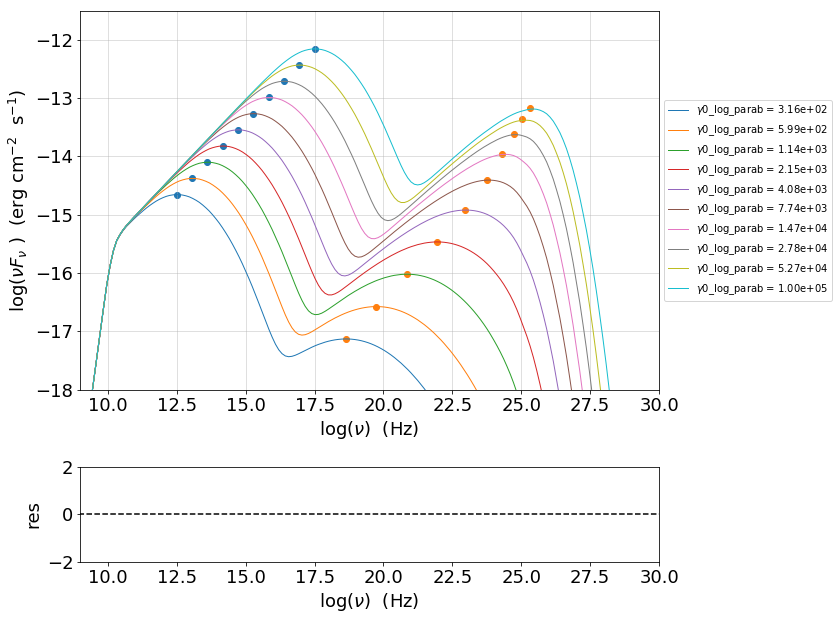

In [197]:
    
my_jet=Jet(electron_distribution='lppl')

matplotlib.rc('font', **font)
p=PlotSED(figsize=(12,9))

size=10

my_jet.parameters.gmax.val=1E8
my_jet.parameters.r.val=1.0
my_jet.parameters.s.val=2.0
my_jet.parameters.N.val=500
my_jet.parameters.z_cosm.val=0.05

my_jet.set_nu_grid_size(200)
my_jet.set_gamma_grid_size(200)
my_jet.set_IC_nu_size(200)

nu_p_S=np.zeros(size)
nu_p_IC=np.zeros(size)
nuFnu_p_S=np.zeros(size)
nuFnu_p_IC=np.zeros(size)
r_S=np.zeros(size)
r_S_err=np.zeros(size)
r_IC=np.zeros(size)
r_IC_err=np.zeros(size)
g_p_e=np.zeros(size)
n3g_p_e=np.zeros(size)

#colors=list(mcolors.CSS4_COLORS)


for ID,gamma0_log_parab in enumerate(np.logspace(2.5,5,size)):
   
   
    my_jet.parameters.gamma0_log_parab.val=gamma0_log_parab
    my_jet.eval()
    my_jet.plot_model(p,comp='Sum',label='$\gamma0$_log_parab = %2.2e'%gamma0_log_parab)
    #with log_log=True, the values are already logarthmic
    x_p,y_p=my_jet.get_component_peak('Sync',log_log=True)
    (nu_p_S[ID],nuFnu_p_S[ID],r_S[ID]),err=get_log_par_peak(x_p,y_p,my_jet,'Sync')
    r_S_err[ID]=err[2]
    
    x_p,y_p=my_jet.get_component_peak('SSC',log_log=True)
    (nu_p_IC[ID],nuFnu_p_IC[ID],r_IC[ID]),err=get_log_par_peak(x_p,y_p,my_jet,'SSC')
    r_IC_err[ID]=err[2]
    g_p_e[ID],n3g_p_e[ID],_=get_gamma_3p(my_jet)
    
p.rescale(y_min=-18,y_max=-11.5,x_min=9)

p.sedplot.scatter(nu_p_S,nuFnu_p_S)
p.sedplot.scatter(nu_p_IC,nuFnu_p_IC)


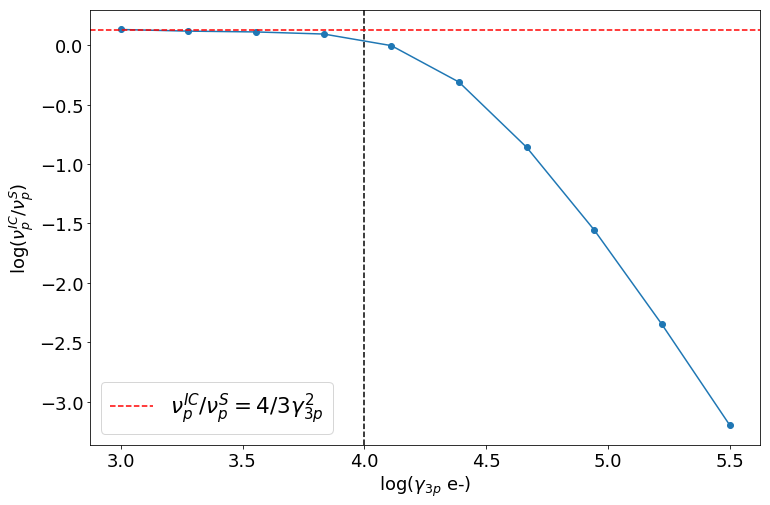

In [198]:
matplotlib.rc('font', **font)

fig = plt.figure(figsize=(12,8))

ax=fig.add_subplot(111)
ax.plot(g_p_e,(nu_p_IC-nu_p_S)-2*g_p_e,'-o')
ax.set_ylabel(r'log($ \nu_p^{IC} / \nu_p^{S} $)''')
ax.set_xlabel(r'log($\gamma_{3p}$ e-)')
ax.axvline(4.0,ls='--',c='black')
ax.axhline(np.log10(4/3),ls='--',c='red',label=r"$ \nu_p^{IC} / \nu_p^{S} =4/3 \gamma_{3p}^2$")
ax.legend(fontsize='large',loc='lower left')

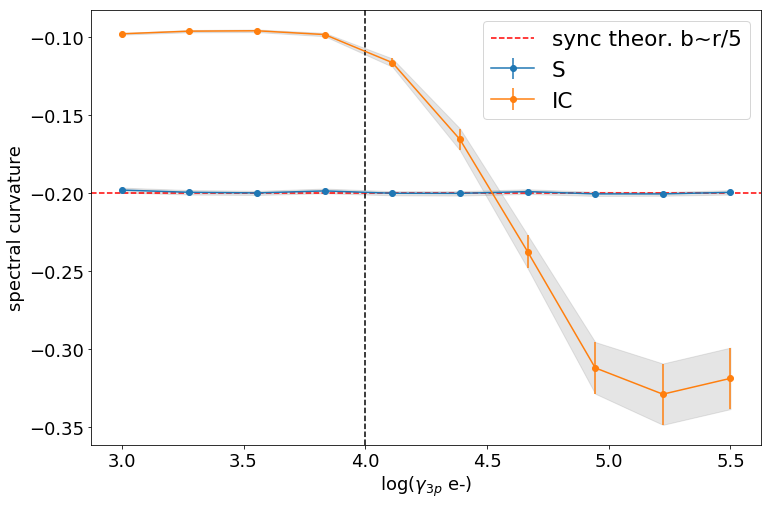

In [199]:
fig = plt.figure(figsize=(12,8))

ax=fig.add_subplot(111)
ax.errorbar(g_p_e,r_S,yerr=r_S_err,fmt='-o',label='S')
ax.fill_between(g_p_e, r_S - r_S_err, r_S + r_S_err,
                 color='gray', alpha=0.2)
ax.errorbar(g_p_e,r_IC,yerr=r_IC_err,fmt='-o',label='IC')
ax.fill_between(g_p_e, r_IC - r_IC_err, r_IC + r_IC_err,
                 color='gray', alpha=0.2)
ax.set_ylabel('spectral curvature')
ax.set_xlabel(r'log($\gamma_{3p}$ e-)')
ax.axvline(4.0,ls='--',c='black')
ax.axhline(-0.2,ls='--',c='red',label='sync theor. b~r/5')
ax.legend(fontsize='large')

# Exercise
derive the trend for the Compton dominance (CD) as a function of N a gamma0_log_parab

hint: use the get_component_peak to extract the peak of the SED for each component